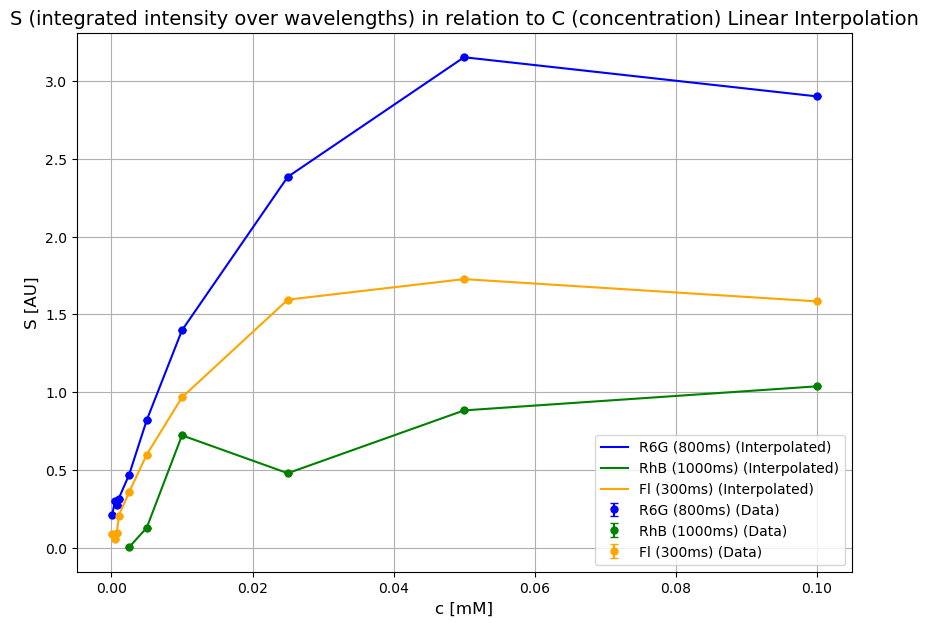

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load the Excel file and specify the sheets to process
file_path = r"C:\Users\oronb\Downloads\The integrated intensities over their wavelength for all 3 materials.xlsx"
sheets = ['R6G int 800', 'RhB int 1000', 'Fl int 300']

# Set up the plot
plt.figure(figsize=(10, 7))

# Define a dictionary of labels for clarity
labels = {
    'R6G int 800': 'R6G (800ms)',
    'RhB int 1000': 'RhB (1000ms)',
    'Fl int 300': 'Fl (300ms)'
}

# Colors for each dataset
colors = ['blue', 'green', 'orange']

# Process each sheet
for i, sheet in enumerate(sheets):
    # Load data from the sheet
    data = pd.read_excel(file_path, sheet_name=sheet)

    # Extract 'c', 's1', and 'ds1' columns
    c = data['c']
    s = data['s1']
    ds = data['ds1']

    # Linear piecewise interpolation
    interp_func = interp1d(c, s, kind='linear', fill_value="extrapolate")
    c_fine = np.linspace(c.min(), c.max(), 500)
    s_fine = interp_func(c_fine)

    # Plot original data with error bars
    plt.errorbar(c, s, yerr=ds, fmt='o', label=f'{labels[sheet]} (Data)', 
                 capsize=3, markersize=5, color=colors[i])
    # Plot interpolated curve
    plt.plot(c_fine, s_fine, '-', label=f'{labels[sheet]} (Interpolated)', color=colors[i])

# Finalize the plot
plt.xlabel('c [mM]', fontsize=12)
plt.ylabel('S [AU]', fontsize=12)
plt.title('S (integrated intensity over wavelengths) in relation to C (concentration) Linear Interpolation', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Results for R6G (800ms):
  a1 = 3.0231 ± 0.0001
  b1 = 68.7918 ± 0.0058
  Reduced Chi-Squared: 3962414.4562
  P-Probability: 0

Results for RhB (1000ms):
  a1 = 1.1771 ± 0.0002
  b1 = 23.9691 ± 0.0066
  Reduced Chi-Squared: 6084696.3555
  P-Probability: 0

Results for Fl (300ms):
  a1 = 1.6905 ± 0.0000
  b1 = 86.9444 ± 0.0038
  Reduced Chi-Squared: 5192027.7670
  P-Probability: 0



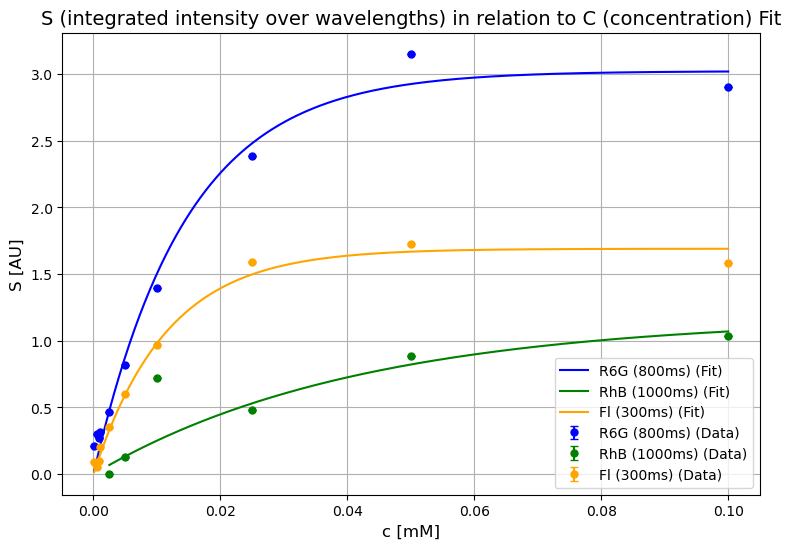

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

# Load the Excel file and specify the sheets to process
file_path = r"C:\Users\oronb\Downloads\The integrated intensities over their wavelength for all 3 materials.xlsx"
sheets = ['R6G int 800', 'RhB int 1000', 'Fl int 300']

# Define the fitting function: f(x) = a1(1 - exp(-b1 * x))
def fit_func(x, a1, b1):
    return a1 * (1 - np.exp(-b1 * x))

# Set up the plot
plt.figure(figsize=(9, 6))

# Define a dictionary of labels for clarity
labels = {
    'R6G int 800': 'R6G (800ms)',
    'RhB int 1000': 'RhB (1000ms)',
    'Fl int 300': 'Fl (300ms)'
}

# Colors for each dataset
colors = ['blue', 'green', 'orange']

# Process each sheet
for i, sheet in enumerate(sheets):
    # Load data from the sheet
    data = pd.read_excel(file_path, sheet_name=sheet)

    # Extract 'c', 's1', and 'ds1' columns
    c = data['c']
    s = data['s1']
    ds = data['ds1']

    # Rescale data to avoid numerical issues if necessary
    scale_factor_c = np.mean(c)
    scale_factor_s = np.mean(s)
    c_scaled = c / scale_factor_c
    s_scaled = s / scale_factor_s
    ds_scaled = ds / scale_factor_s

    # Perform the curve fitting
    initial_guess = [1, 1]  # Initial guesses for a1, b1
    params, params_covariance = curve_fit(
        fit_func, c_scaled, s_scaled, sigma=ds_scaled, p0=initial_guess, absolute_sigma=True
    )

    # Extract fitted parameters and their errors
    a1_scaled, b1_scaled = params
    param_errors_scaled = np.sqrt(np.diag(params_covariance))  # Standard errors

    # Scale back the parameters and errors
    a1 = a1_scaled * scale_factor_s
    b1 = b1_scaled / scale_factor_c
    param_errors = param_errors_scaled * [scale_factor_s, 1 / scale_factor_c]

    # Calculate residuals and chi-squared
    residuals = (s - fit_func(c, a1, b1))
    chi_squared = np.sum((residuals / ds) ** 2)
    dof = len(c) - len(params)  # Degrees of freedom
    chi_squared_reduced = chi_squared / dof

    # Compute the p-probability
    p_probability = 1 - chi2.cdf(chi_squared, dof)

    # Print results for this dataset
    print(f"Results for {labels[sheet]}:")
    print(f"  a1 = {a1:.4f} ± {param_errors[0]:.4f}")
    print(f"  b1 = {b1:.4f} ± {param_errors[1]:.4f}")
    print(f"  Reduced Chi-Squared: {chi_squared_reduced:.4f}")
    print(f"  P-Probability: {p_probability:.4g}")
    print()

    # Generate fitted curve
    c_fine = np.linspace(c.min(), c.max(), 500)
    s_fit = fit_func(c_fine, a1, b1)

    # Plot original data with error bars
    plt.errorbar(c, s, yerr=ds, fmt='o', label=f'{labels[sheet]} (Data)', 
                 capsize=3, markersize=5, color=colors[i])
    # Plot fitted curve
    plt.plot(c_fine, s_fit, '-', label=f'{labels[sheet]} (Fit)', color=colors[i])

# Finalize the plot
plt.xlabel('c [mM]', fontsize=12)
plt.ylabel('S [AU]', fontsize=12)
plt.title('S (integrated intensity over wavelengths) in relation to C (concentration) Fit', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

